# Exercise 2: Training Deep Neural Network on CIFAR-10

Before i try to build a DNN i quickly want to analyze and look at the CIFAR-10 dataset:

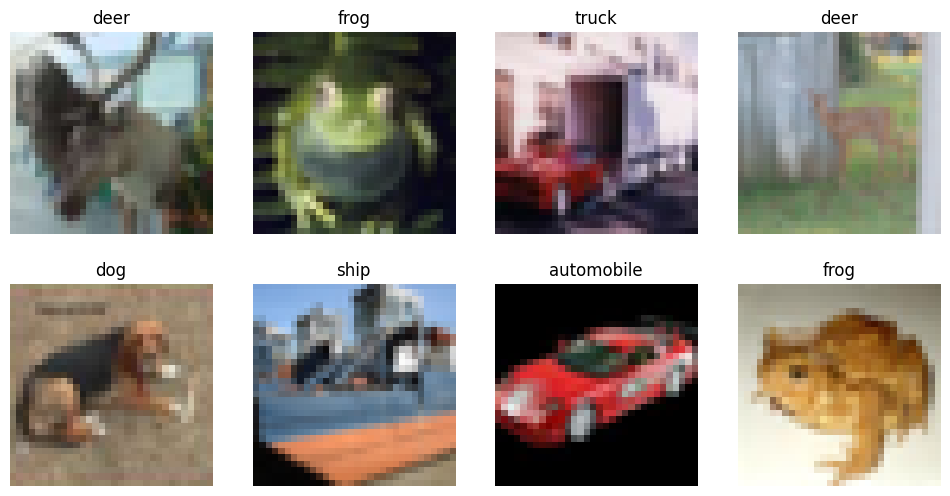

In [23]:
import matplotlib.pyplot as plt
import torch

seed = 13
torch.manual_seed(seed)  # reproducible 
indices = torch.randperm(len(train_ds))[:8]
images = torch.stack([train_ds[i][0] for i in indices])
labels = torch.tensor([train_ds[i][1] for i in indices])
classes = train_full.classes

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = images[i] / 2 + 0.5           # unnormalize
    img = img.permute(1,2,0).numpy()    # C,H,W -> H,W,C
    plt.imshow(img)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()


yupp those sure are images with 32x32 pixels with 3 channels for color (RGB)

### Imports and set seed 

In [24]:
import torch, random
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataloading and preperation

In [25]:
tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_full = datasets.CIFAR10('./data', train=True, download=True, transform=tfm)
test_full = datasets.CIFAR10('./data', train=False, download=True, transform=tfm)

train_ds, test_ds = Subset(train_full, range(5000)), Subset(test_full, range(1000))
val_size = 1000; train_size = len(train_ds)-val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)
test_dl = DataLoader(test_ds, batch_size=128)

### Model definition and training

Epoch 01: Train 2.3330, Val 2.2417
Epoch 02: Train 1.6571, Val 2.2981
Epoch 03: Train 1.3381, Val 2.1495
Epoch 04: Train 1.1202, Val 2.0213
Epoch 05: Train 0.9122, Val 2.3248
Epoch 06: Train 0.7150, Val 2.2676
Epoch 07: Train 0.5580, Val 2.6816
Epoch 08: Train 0.4218, Val 2.3159
Epoch 09: Train 0.3229, Val 2.9176
Early stop.

Test Accuracy: 34.80%


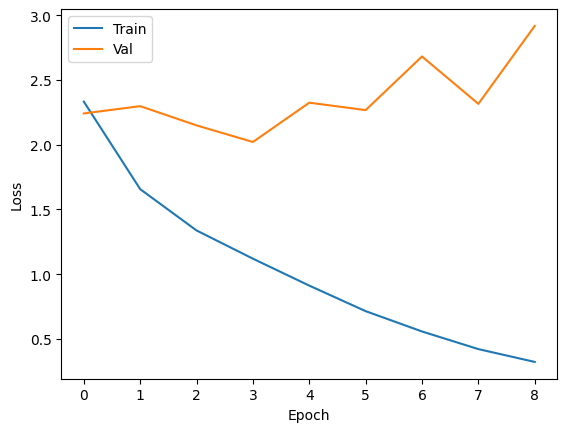

In [26]:

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 256), nn.ELU(),
            nn.Linear(256, 256), nn.ELU(),
            nn.Linear(256, 256), nn.ELU(),
            nn.Linear(256, 256), nn.ELU(),
            nn.Linear(256, 10)
        )
        for m in self.net:
            if isinstance(m, nn.Linear): nn.init.kaiming_normal_(m.weight)
    def forward(self, x): return self.net(x)

model = DNN().to(device)
opt = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# --- Training ---
patience, best, wait = 5, 1e9, 0
train_l, val_l = [], []
for e in range(50):
    model.train()
    running_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    tl = running_loss / len(train_dl)

    model.eval(); val_loss = 0
    with torch.no_grad():
        for x, y in val_dl:
            val_loss += loss_fn(model(x.to(device)), y.to(device)).item()
    vl = val_loss / len(val_dl)
    train_l.append(tl); val_l.append(vl)
    print(f"Epoch {e+1:02d}: Train {tl:.4f}, Val {vl:.4f}")

    if vl < best: best, wait, best_w = vl, 0, model.state_dict().copy()
    else:
        wait += 1
        if wait >= patience: print("Early stop."); break

model.load_state_dict(best_w)


model.eval(); correct = total = 0
with torch.no_grad():
    for x, y in test_dl:
        p = model(x.to(device)).argmax(1)
        correct += (p.cpu() == y).sum().item(); total += y.size(0)
test_acc = 100*correct/total
print(f"\nTest Accuracy: {test_acc:.2f}%")

# --- Plot ---
plt.plot(train_l, label='Train'); plt.plot(val_l, label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()


# Step by Step Breakdown – Exercise 2 (CIFAR-10)
Very similar code to Q1, just with different parameters and a different dataset (CIFAR-10).

In Q1 we worked with 28×28 = 784 grayscale images (handwritten digits), but now we have 32×32×3 = 3072 features, meaning we are working with color images instead of simple grayscale digits. This makes the task more complex because objects have more variation, textures, and backgrounds.

We are now working with more data samples in both training and test samples. (5000 training, 1000 test vs 1000 training, 200 test that we had in Q1). But we did the same data loading and preparation and wrap the datasets in DataLoaders for batch processing. 

### Model definition
This time the ```Flatten()``` converts each 32x32x3 image into a 3072 lenght vector and now with 4 hidden layers instead of 3 and each layer with 256 neurons instead of 64 neurons each . The output layer still has 10 neurons. 

### Training setup
The optimizer has the same parameters with NAdam optimizer with a learning rate of 0.001 using CrossEntropyLoss as the loss function. 

### Training loop
The requirements for early stopping is the same with patience being at 5, with 50 epochs but with batch sizes of 128 rather than 32. 

### Testing, why was the accuracy on this one so much lower?
After training, the model tried itself on 1000 test samples. For each batch we predict the class with the highest probability (argmax). From this seed we got an accuracy of 34.8% which is drastically lower than Q1's almost 90%. 


This can be for multiple reasons. As i mentioned this dataset much more complex and diverse, for this the small increase in training subset does not match with the increase in complexity. 